In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jugador import JugadorAleatorio, JugadorEntrenado, JugadorSiempreSePlanta
from agente import AgenteQLearning
from ambiente import AmbienteDiezMil
from validador import Validador
from utils import RangeSnaper
from diezmil import JuegoDiezMil
from tqdm import tqdm

In [7]:
# Inicialización del gráfico
def train(epochs, episodios, alpha, gamma, epsilon, rs, early_stop = 20, seed = 42, recompensa_i: int = 0, penalidad_i: int = 0, multiplicador_recompensa: int = 1):   
    seed = seed
    np.random.seed(seed)

    ambiente = AmbienteDiezMil(rs=rs, recompensa_i=recompensa_i, penalidad_i=penalidad_i, multiplicador_recompensa=multiplicador_recompensa)

    # Crear un agente de Q-learning
    agente = AgenteQLearning(ambiente, alpha=alpha, gamma=gamma, epsilon=epsilon)


    best_validation = Validador(AmbienteDiezMil(rs=rs)).validar_politica(agente.q_table2pol(), 500)
    validacion = [best_validation]
    best_policy = None
    epochs_sin_mejora = 0
    # Entrenar al agente con un número de episodios
    for _ in tqdm(range(epochs)):
        agente.entrenar(episodios, verbose=False)
        if _ % 2 == 0:
            validador = Validador(AmbienteDiezMil(rs=rs, recompensa_i=recompensa_i, penalidad_i=penalidad_i, multiplicador_recompensa=multiplicador_recompensa))
            validacion.append(validador.validar_politica(agente.q_table2pol(), 300))
            if validacion[-1] < best_validation:
                best_validation = validacion[-1]
                best_policy = agente.q_table2pol()
                epochs_sin_mejora = 0
            else:
                epochs_sin_mejora += 1
                if epochs_sin_mejora == early_stop:
                    break
    
    return best_validation, best_policy, validacion

 72%|███████▏  | 216/300 [01:06<00:25,  3.26it/s]


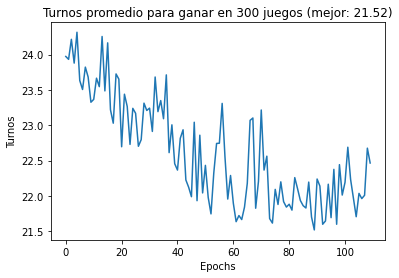

21.52


In [19]:
bv, bp, vn = train(300, 100, 0.01, 0.9, 0.1, RangeSnaper())

plt.plot(vn)
plt.title("Turnos promedio para ganar en 300 juegos (mejor: {})".format(bv))
plt.xlabel("Epochs")
plt.ylabel("Turnos")
plt.show()
print(bv)

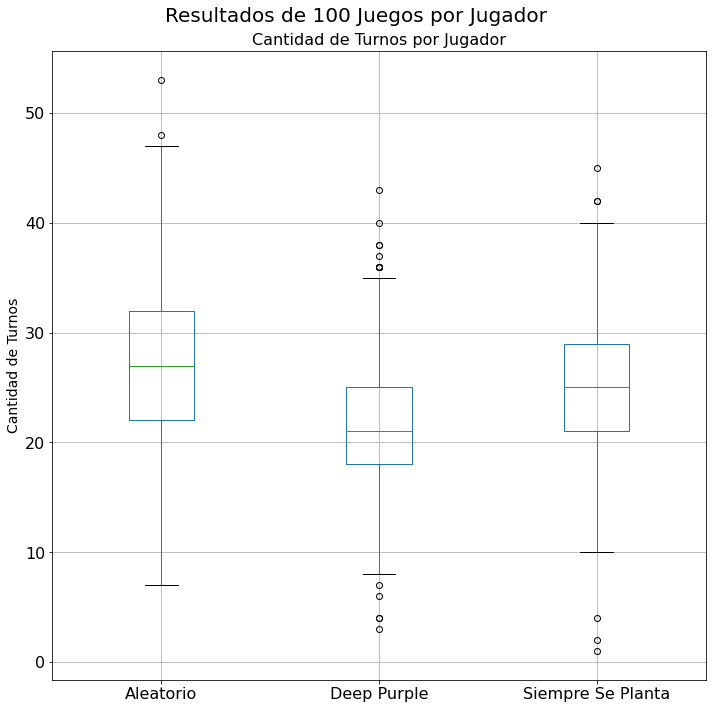

In [29]:
# Definir los jugadores
RANGOS = [
    (0, 1),
    (1, 250),
    (250, 500),
    (500, 750),
    (750, 1000),
    (1000, 5000),
    (5000, int(1e10))
]


jugadores = [
    JugadorEntrenado("Deep Purple","politicas/hyperopt.csv", RangeSnaper(RANGOS)),
    JugadorAleatorio("Aleatorio"),
    JugadorSiempreSePlanta("Siempre Se Planta"),
]

# Inicializar una lista para almacenar los resultados
resultados = []
n_sims = 1000

# Simular 100 juegos para cada jugador
for jugador in jugadores:
    for _ in range(n_sims):

        juego = JuegoDiezMil(jugador)
        cantidad_turnos, puntaje_final = juego.jugar(verbose=False)
        resultados.append(
            {
                "jugador": jugador.nombre,
                "cantidad_turnos": cantidad_turnos,
                "puntaje_final": puntaje_final,
            }
        )

# Convertir los resultados a un DataFrame
df_resultados = pd.DataFrame(resultados)

# Graficar los resultados
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

# Graficar la cantidad de turnos
df_resultados.boxplot(column="cantidad_turnos", by="jugador", ax=axes)
axes.set_title("Cantidad de Turnos por Jugador", fontsize=16)
axes.set_xlabel("")
axes.set_ylabel("Cantidad de Turnos", fontsize=14)

axes.tick_params(axis='both', which='major', labelsize=16)
# axes.tick_params(axis='both', which='minor', labelsize=8)

# # Graficar el puntaje final
# df_resultados.boxplot(column="puntaje_final", by="jugador", ax=axes[1])
# axes[1].set_title("Puntaje Final por Jugador")
# axes[1].set_xlabel("Jugador")
# axes[1].set_ylabel("Puntaje Final")

plt.suptitle("Resultados de 100 Juegos por Jugador", fontsize=20)
plt.tight_layout()
plt.show()